## Analisis next100 in IC

### Input files:

In [1]:
input_files = "/Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-000-.next.h5"
!ls /Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-*-.next.h5

/Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-000-.next.h5
/Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-001-.next.h5
/Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-002-.next.h5
/Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-003-.next.h5
/Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-004-.next.h5
/Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-005-.next.h5
/Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-006-.next.h5
/Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-007-.next.h5
/Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-008-.next.h5
/Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-009-.next.h5


### Imports

In [2]:
import sys
import os
import shutil
import functools
import time
import glob

%matplotlib inline
print("Running on ", time.asctime())

import numpy             as np
#import tables            as tb
import tables            
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import pandas as pd

from collections import namedtuple


Running on  Fri Apr 13 15:44:54 2018


In [3]:
import platform
platform.python_version()

'3.6.5'

In [4]:
from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import covariance
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import plot_writer
from invisible_cities.icaro.hst_functions import measurement_string

from invisible_cities.icaro.mpl_functions import plt_scatter3d,plt_scatter2d


In [5]:
from networkx                   import Graph
from invisible_cities.evm.event_model         import Voxel
from invisible_cities.evm.event_model         import VoxelCollection
from invisible_cities.core.exceptions         import NoHits
from invisible_cities.core.exceptions         import NoVoxels
from invisible_cities.evm.event_model         import BHit
from invisible_cities.evm.event_model         import Voxel
from invisible_cities.evm.event_model         import Track
from invisible_cities.evm.event_model         import Blob
from invisible_cities.evm.event_model         import TrackCollection
from invisible_cities.core.system_of_units_c  import units

from invisible_cities.reco.paolina_functions  import *
from invisible_cities.io.mcinfo_io            import *

### <u> Energy Smearing </u> : $ ~~~~ E_{tot} \to E'_{tot}$, obtain ratio $F = E'_{tot}/E_{tot}$

The smearing takes into account that the energy resolution at the $Q_{\beta\beta}$ is 0.75% FWHM; 

and the relation that the resolution as a function of E follows:  $1/\sqrt(E)$ from $\frac{\sigma(E)}{E} = \frac{a}{\sqrt E}$, where $a$ is the stochastic term

Inputs: 1) energy resolution in % and FWHM at $Q_{\beta\beta}$, 2) energy of the event $E$

Steps: 

 a) obtain resolution at the given energy: $\sigma$       (FWHM = $2 ~ \sqrt{2~ ln ~ 2}~ \sigma$ )

 b) build a Gaussian function with $\mu$ energy of the event and $\sigma$ obtained in a) ---> TODO: gaussian 0 ,1 
       
 c) obtain $E'_{tot}$ from the Gaussian in in **b)**
 
 
 
 ### Function:
     1. fwhm_at_Qvalue in %
     2. event_energy in MeV
     3. sigma_at_Qvalue and sigma_at_event_energy adimensional
     4. returns smear_energy adimensional from a Gaussian centered in 1 and sigma sigma_at_event_energy



In [6]:
smearing = namedtuple("Smearing", ['factor', 'energy'])


def fwhm_at_event_energy (fwhm_at_Qvalue, event_energy):
    Qvalue = 2.458
    fwhm_at_event_energy = fwhm_at_Qvalue * np.sqrt(Qvalue) / np.sqrt(event_energy)
    return fwhm_at_event_energy

def smeared_energy ( fwhm_at_Qvalue, event_energy ):
    fwhm   = fwhm_at_event_energy (fwhm_at_Qvalue, event_energy)
    sigma  = fwhm / (100 * 2 * np.sqrt(2*np.log(2)))
    smearing_factor = np.random.normal( 1 ,sigma)
    event_energy_smear = event_energy * smearing_factor
    return smearing(factor = smearing_factor, energy = event_energy_smear)

#### Smearing of voxels:     $~~~~~E'_{vox}= E_{vox}/E_{tot} \times E'_{tot}$


In [7]:
def smeared_energy_voxel (evoxel, etot, e_smear ):
    return evoxel * e_smear / etot   

### <u> Fiducial cut </u>:   
exclude a region of <font color=red> **20 mm** </font> around the boundaries of the active volume, a) for the smear voxel and b) for the original voxel

Exclude events with voxels located in the vetoed region with energy above **10 keV** (the detection threshold of the tracking plane)

Dimensions of next100 detector: **anodePos, cathodePos, radius =  (0., 1300., 534.5)** mm

### $x^2+y^2 < 534.5-fid$

### Next100 signal or bkg events:
Use function **load_mchits** to get a dictionary whose keys are ID_number and values are a list of **MCHit** (from the IC Event Model) objects


### Loop over files, loop over MCHits and save np.arrays for:
Es, voxels coordinates, voxels energies

$~~~~$

me falta: 
       
    1. propagar la energía smeared de los voxels a la energía de los voxels de los blobs. Ahora estoy representando la energía original de los blobs, como se puede ver en el plot no cambía mucho ). Nota: la función smeared devuelve el smearing factor para evitar crear nuevos smearings en la selección.
                        
    2. añadir al corte fiducial corte en energía de 10 keV.
      


In [8]:
print("Running on ", time.asctime())

# cuts (energies in MeV, dimensions in mm)
emin      = 2.4 
emax      = 2.5
tpc_radius = 534.5 
fid_cut    = 20.0
fid        = tpc_radius - fid_cut
zmin       = 0. - fid_cut
zmax       = 1200.0 - fid_cut 
trk_minE   = 0.003
blob_minE  = 0.3 

# parameters
voxel_dim    = np.array([10,10,10]) # mm
blob_radius  = 17.3 # mm
contiguity   = 18 # mm; sqrt(3) corresponde a exigir que los voxels se toquen por un CORNER en el algoritmo de Dijkstra

# counters
ev_tot          = 0
c_Es_smear      = 0
c_fid           = 0
c_single_track  = 0
c_trk_minE      = 0
c_blob_minE     = 0

# output variables to plot
lEs        = []
lEs_smear  = []
lv_x       = []
lv_y       = []
lv_z       = []
lv_E       = []
lv_E_smear = []
lnum_trk   = []
ltrk_E     = []
lblob1_E   = []
lblob2_E   = []


for input_file in glob.glob(input_files):
    
    print(input_file)
    hitd =  load_mchits(input_file)
    
    for hits in hitd.values():
        fiducial_cut     = False 
        single_track_cut = False 
        trk_minE_cut     = False
        blob_minE_cut    = False
        
        Es = sum(hit.E for hit in hits) 
        Es_smear = smeared_energy(0.75, Es).energy
        lEs      .append(Es)
        lEs_smear.append(Es_smear)
        
        if( emin < Es_smear < emax ):
            c_Es_smear += 1
            voxels = voxelize_hits(hits,voxel_dim)
            
                    
            #lv_E = [voxel.E for voxel in voxels]
            #lv_x = [voxel.X for voxel in voxels]
            #lv_y = [voxel.Y for voxel in voxels]
            #lv_z = [voxel.Z for voxel in voxels]
            for voxel in voxels:
                lv_E.append(voxel.E)
                lv_x.append(voxel.X)
                lv_y.append(voxel.Y)
                lv_z.append(voxel.Z)
                #%timeit smeared_energy_voxel(voxel.E, Es, Es_smear)
                lv_E_smear.append(smeared_energy_voxel(voxel.E, Es, Es_smear))
                
                if( (np.sqrt( voxel.X**2 + voxel.Y**2) < fid ) and zmin < voxel.Z < zmax ):
                    fiducial_cut = True
                    #%timeit make_tracks(1, 2, voxels, voxel_dim, 18, 17.3)
                    trks = make_tracks(1, 2, voxels, voxel_dim, 18, 17.3)
                    if (trks.number_of_tracks == 1):
                        single_track_cut = True
                        lnum_trk.append(trks.number_of_tracks)
                    
                        for trk in trks.tracks:
                            if (trk.E > trk_minE):
                                trk_minE_cut = True
                                ltrk_E.append(trk.E)
                                if(trk.blobs[0].E > blob_minE and trk.blobs[1].E > blob_minE ):
                                    blob_minE_cut = True
                                    lblob1_E.append(trk.blobs[0].E)
                                    lblob2_E.append(trk.blobs[1].E)
                                    
        if ( fiducial_cut )     : c_fid            += 1
        if ( single_track_cut ) : c_single_track   += 1
        if ( trk_minE_cut )     : c_trk_minE       += 1
        if ( blob_minE_cut)     : c_blob_minE      += 1
 
    ev_tot = ev_tot + len(hitd)
  
print("+++++++-------------------------------------------------+++++++\n")
print("Total events analized = " + str(ev_tot))
print("Events passing energy smearing cut           = " + str(c_Es_smear))
print("Events passing fiducial cut                  = " + str(c_fid))
print("Events passing single track                  = " + str(c_single_track))
print("Events passing energy track cut              = " + str(c_trk_minE))
print("Events passing energy blob min energy cut    = " + str(c_blob_minE))
#print("Efficiency = "+c_blob_minE/ev_tot +" %")
print("\n")     
print("+++++++-------------------------------------------------+++++++")

print("Running on ", time.asctime())

Es        = np.array(lEs)
Es_smear  = np.array(lEs_smear)

v_E = np.array(lv_E)
v_E_smear = np.array(lv_E_smear)

v_x = np.array(lv_x)
v_y = np.array(lv_y)
v_z = np.array(lv_z)

num_trk = np.array(lnum_trk)
trk_E   = np.array(ltrk_E)
blob1_E = np.array(lblob1_E)
blob2_E = np.array(lblob2_E)


Running on  Fri Apr 13 15:44:57 2018
/Users/neus/current-work/nexus-files/data-next100-IC/bb0nu/bb0nu-000-.next.h5
+++++++-------------------------------------------------+++++++

Total events analized = 773
Events passing energy smearing cut           = 750
Events passing fiducial cut                  = 714
Events passing single track                  = 512
Events passing energy track cut              = 512
Events passing energy blob min energy cut    = 470


+++++++-------------------------------------------------+++++++
Running on  Fri Apr 13 16:08:38 2018


Text(0.5,0,'voxels energy - voxels energy smeared (MeV)')

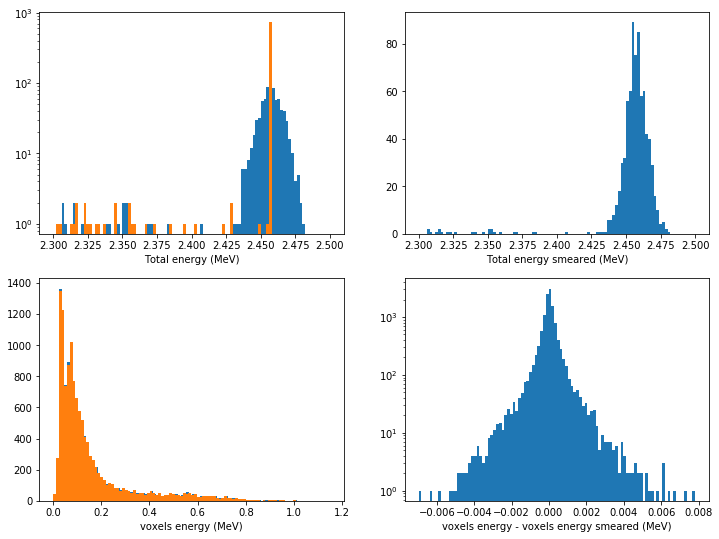

In [9]:
len(Es_smear)
fig = plt.figure(figsize = (12,9))
bins = 100

ax1 = fig.add_subplot(2,2,1)
plt.hist(Es_smear,bins,[2.3,2.5])
plt.hist(Es,100,[2.3,2.5])
plt.yscale('log', nonposy='clip')
plt.xlabel('Total energy (MeV)')

ax2 = fig.add_subplot(2,2,2)
plt.hist(Es_smear,bins,[2.3,2.5])
plt.xlabel('Total energy smeared (MeV)')


ax3 = fig.add_subplot(2,2,3)
plt.hist(v_E_smear, bins, stacked=True)
plt.hist(v_E, bins, stacked=True, )
plt.xlabel('voxels energy (MeV)')


ax4 = fig.add_subplot(2,2,4)
plt.yscale('log', nonposy='clip')
plt.hist(v_E - v_E_smear, bins)
plt.xlabel('voxels energy - voxels energy smeared (MeV)')



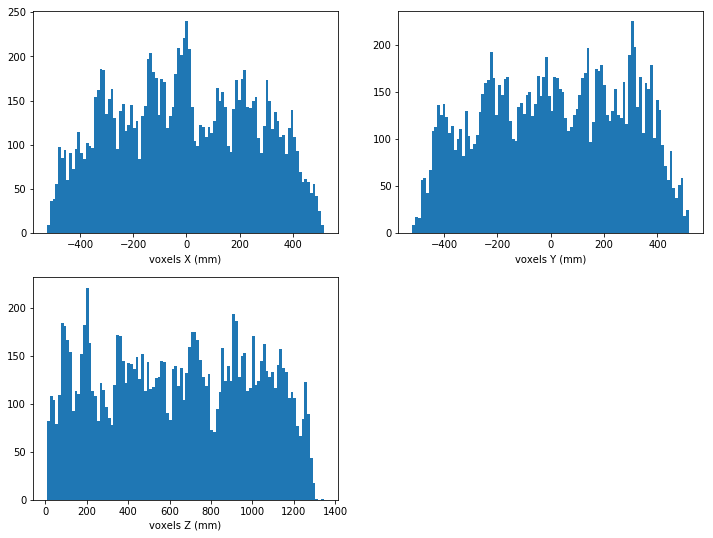

In [10]:
bins = 100

fig = plt.figure(figsize = (12,9))

ax1 = fig.add_subplot(2,2,1)
plt.hist(v_x, bins)
plt.xlabel('voxels X (mm)')

ax2 = fig.add_subplot(2,2,2)
plt.hist(v_y, bins)
plt.xlabel('voxels Y (mm)')

ax3 = fig.add_subplot(2,2,3)
plt.hist(v_z, bins)
plt.xlabel('voxels Z (mm)')

plt.show()



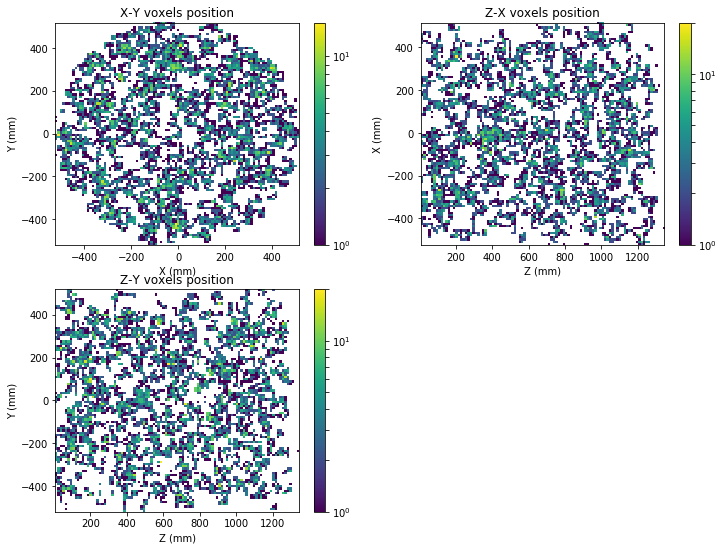

In [11]:
bins = 100

fig = plt.figure(figsize = (12,9))
ax1 = fig.add_subplot(2,2,1)
plt.hist2d(v_x, v_y, bins, norm=LogNorm())
plt.colorbar()
plt.title('X-Y voxels position')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')


ax2 = fig.add_subplot(2,2,2)
plt.hist2d(v_z, v_x, bins, norm=LogNorm())
plt.colorbar()
plt.title('Z-X voxels position')
plt.xlabel('Z (mm)')
plt.ylabel('X (mm)')

ax3 = fig.add_subplot(2,2,3)
ax3.hist2d(v_z, v_y, bins, norm=LogNorm())
plt.colorbar()
plt.title('Z-Y voxels position')
plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.show()


### Weighted by initial energy 

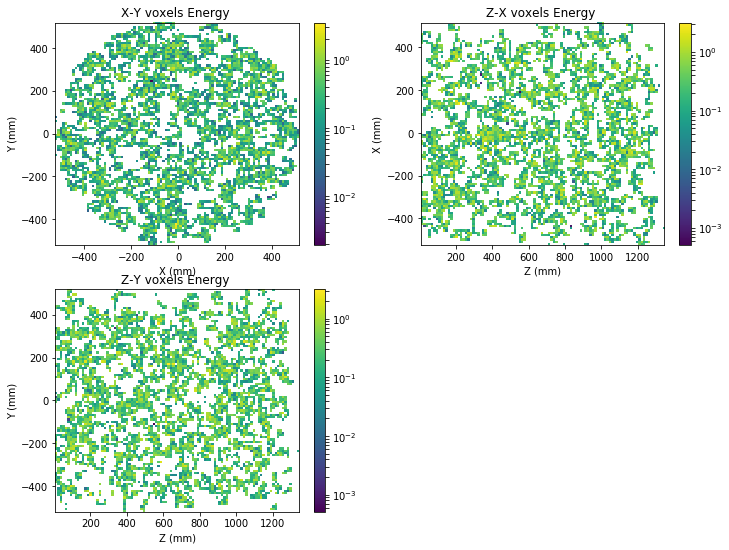

In [12]:
bins = 100
w = v_E 

fig = plt.figure(figsize = (12,9))
ax1 = fig.add_subplot(2,2,1)
plt.hist2d(v_x, v_y, bins, weights = w, norm=LogNorm())
plt.colorbar()
plt.title('X-Y voxels Energy ')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')


ax2 = fig.add_subplot(2,2,2)
plt.hist2d(v_z, v_x, bins, weights = w, norm=LogNorm())
plt.colorbar()
plt.title('Z-X voxels Energy ')
plt.xlabel('Z (mm)')
plt.ylabel('X (mm)')

ax3 = fig.add_subplot(2,2,3)
ax3.hist2d(v_z, v_y, bins, weights = w, norm=LogNorm())
plt.colorbar()
plt.title('Z-Y voxels Energy ')
plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.show()

### Weighted by smeared energy 

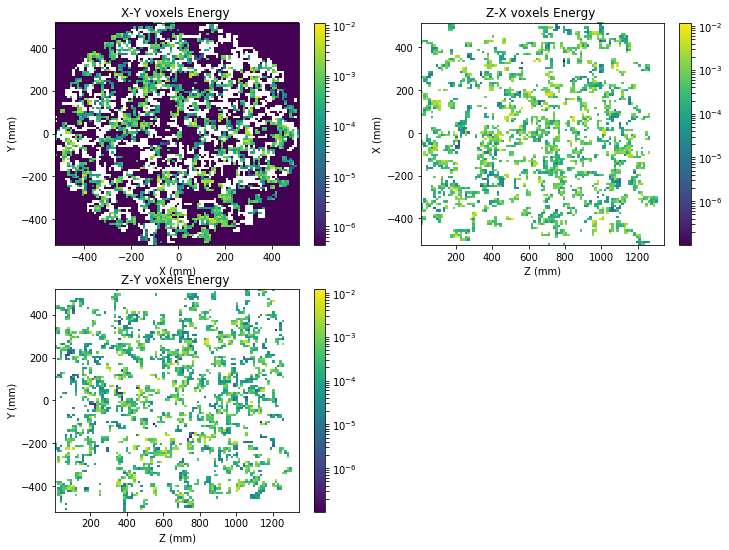

In [13]:
bins = 100
w = v_E - v_E_smear

fig = plt.figure(figsize = (12,9))
ax1 = fig.add_subplot(2,2,1)
plt.hist2d(v_x, v_y, bins, weights = w, norm=LogNorm())
plt.colorbar()
plt.title('X-Y voxels Energy ')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')


ax2 = fig.add_subplot(2,2,2)
plt.hist2d(v_z, v_x, bins, weights = w, norm=LogNorm())
plt.colorbar()
plt.title('Z-X voxels Energy ')
plt.xlabel('Z (mm)')
plt.ylabel('X (mm)')

ax3 = fig.add_subplot(2,2,3)
ax3.hist2d(v_z, v_y, bins, weights = w, norm=LogNorm())
plt.colorbar()
plt.title('Z-Y voxels Energy ')
plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.show()

### Energy Tracks and blobs energy

In [14]:
num_trk = np.array(lnum_trk)
trk_E   = np.array(ltrk_E)
blob1_E = np.array(lblob1_E)
blob2_E = np.array(lblob2_E)



Text(0.5,0,'number of tracks per event')

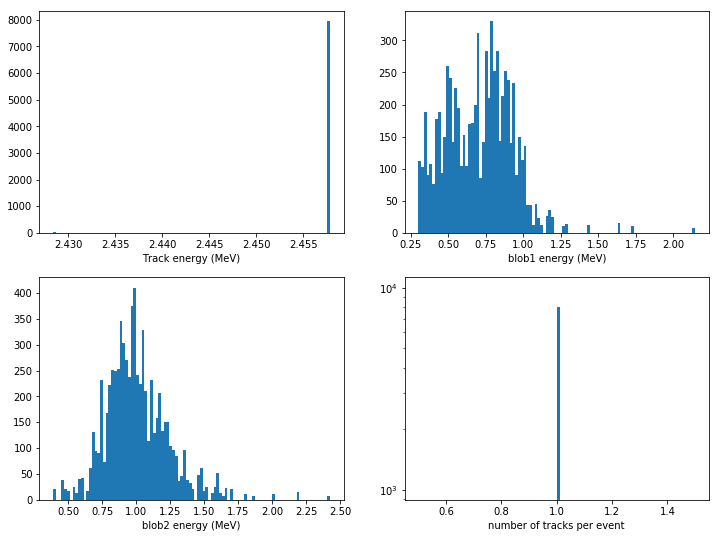

In [15]:
bins = 100
w = v_E - v_E_smear

fig = plt.figure(figsize = (12,9))

ax1 = fig.add_subplot(2,2,1)
plt.hist(trk_E,100)
plt.xlabel('Track energy (MeV)')

ax2 = fig.add_subplot(2,2,2)
plt.hist(blob1_E,100)
plt.xlabel('blob1 energy (MeV)')


ax3 = fig.add_subplot(2,2,3)
plt.hist(blob2_E, bins, stacked=True)
plt.xlabel('blob2 energy (MeV)')


ax4 = fig.add_subplot(2,2,4)
plt.yscale('log', nonposy='clip')
plt.hist( num_trk, bins )
plt.xlabel('number of tracks per event')



Text(0,0.5,'e2')

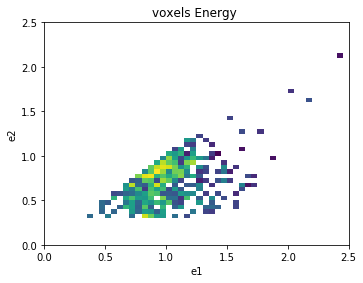

In [16]:
bins = 50 

fig = plt.figure(figsize = (12,9))
ax1 = fig.add_subplot(2,2,1)
plt.hist2d(blob2_E, blob1_E, bins, [[0.0, 2.5], [0.0, 2.5]] , norm=LogNorm())
#plt.colorbar()
plt.title('voxels Energy ')
plt.xlabel('e1')
plt.ylabel('e2')

